1.收集北京市昌平区霍营二手房销售数据

In [6]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
import pandas as pd
import time

def clean_numeric(text):
    """
    清洗数字中的非数值字符（如逗号、汉字单位等）
    """
    return ''.join(filter(str.isdigit, text))

def init_driver():
    """初始化浏览器驱动"""
    service = Service(ChromeDriverManager().install())
    return webdriver.Chrome(service=service)

def scrape_sales_data(pages=7):
    """
    爬取二手房销售数据
    网页链接：https://esf.fang.com/house-a012-b02697/
    返回数据格式：(面积, 总价, 单价)
    """
    driver = init_driver()
    data = []
    base_url = 'https://esf.fang.com/house-a012-b02697/'

    try:
        for page in range(1, pages+1):
            # 构造分页URL（第一页无页码后缀）
            url = base_url if page == 1 else f"{base_url}i3{page}/"
            print(f"正在抓取销售页面：{url}")
            driver.get(url)

            # 等待加载
            WebDriverWait(driver, 15).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, "div.shop_list"))
            )

            # 滚动页面确保加载完整
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(1)

            # 定位房产条目（排除隐藏元素）
            houses = driver.find_elements(
                By.CSS_SELECTOR, 
                "div.shop_list > dl.clearfix:not(.hiddenMap)"
            )

            for house in houses:
                try:
                    # 提取面积信息
                    area_text = house.find_element(By.CSS_SELECTOR, "p.tel_shop").text
                    area = next(p.replace('㎡','').strip() for p in area_text.split('|') if '㎡' in p)
                    
                    # 提取价格信息
                    price_section = house.find_element(By.CSS_SELECTOR, "dd.price_right")
                    total_price = price_section.find_element(By.CSS_SELECTOR, "span.red b").text
                    unit_price = price_section.find_element(
                        By.XPATH, ".//span[contains(text(), '元/㎡')]"
                    ).text.replace('元/㎡','')

                    # 转换为数值并进行去重检查
                    entry = (
                        float(clean_numeric(area)),
                        float(clean_numeric(total_price)),
                        float(clean_numeric(unit_price))
                    )
                    if entry not in data:
                        data.append(entry)

                except Exception as e:
                    print(f"销售数据提取失败：{str(e)}")
                    continue

            print(f"销售第 {page} 页完成，累计数据：{len(data)}条")
            time.sleep(1)

    except Exception as e:
        print(f"销售数据抓取异常：{str(e)}")
    finally:
        driver.quit()
    
    return data

def scrape_rental_data(pages=1):
    """
    抓取租房数据
    网页链接：https://zu.fang.com/house-a012-b02697/
    返回数据格式：(面积, 租金)
    """
    driver = init_driver()
    data = []
    base_url = 'https://zu.fang.com/house-a012-b02697/'

    try:
        for page in range(1, pages+1):
            # 构造分页URL（第一页无页码后缀）
            url = f"{base_url}i3{page}/" if page >1 else base_url
            print(f"正在抓取租房页面：{url}")
            driver.get(url)

            # 等待列表加载
            WebDriverWait(driver, 15).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, "dl.list.hiddenMap.rel"))
            )

            # 滚动页面加载动态内容
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(1)

            # 定位租房条目
            houses = driver.find_elements(By.CSS_SELECTOR, "dl.list.hiddenMap.rel")

            for house in houses:
                try:
                    # 提取面积
                    area_text = house.find_element(By.CSS_SELECTOR, "p.font15.mt12.bold").text
                    area = next(x.strip().replace('㎡','') for x in area_text.split('|') if '㎡' in x)
                    
                    # 提取租金
                    price = house.find_element(By.CSS_SELECTOR, "div.moreInfo span").text.replace('元/月','')

                    # 数据转换与去重检查
                    entry = (
                        float(clean_numeric(area)),
                        float(clean_numeric(price))
                    )
                    if entry not in data:
                        data.append(entry)

                except Exception as e:
                    print(f"租房数据提取失败：{str(e)}")
                    continue

            print(f"租房第 {page} 页完成，累计数据：{len(data)}条")
            time.sleep(1)

    except Exception as e:
        print(f"租房数据抓取异常：{str(e)}")
    finally:
        driver.quit()
    
    return data

def save_data(data, columns, filename):
    """
    数据保存函数
    参数：
    - data: 待保存的数据列表
    - columns: Excel列名
    - filename: 输出文件名
    """
    if data:
        df = pd.DataFrame(data, columns=columns)
        df.drop_duplicates(inplace=True)
        df.to_excel(filename, index=False)
        print(f"文件保存成功：{filename}（{len(df)}条）")
    else:
        print("无有效数据需要保存")

if __name__ == "__main__":
    # 执行二手房销售数据采集
    sales = scrape_sales_data(pages=7)  
    save_data(sales, ["面积(㎡)", "总价(万)", "单价(元/㎡)"], "二手房销售数据_霍营.xlsx")

    # 执行租房数据采集
    rentals = scrape_rental_data(pages=1)
    save_data(rentals, ["面积(㎡)", "租金(元/月)"], "租房数据_霍营.xlsx")

正在抓取销售页面：https://esf.fang.com/house-a012-b02697/
销售第 1 页完成，累计数据：42条
正在抓取销售页面：https://esf.fang.com/house-a012-b02697/i32/
销售第 2 页完成，累计数据：82条
正在抓取销售页面：https://esf.fang.com/house-a012-b02697/i33/
销售第 3 页完成，累计数据：116条
正在抓取销售页面：https://esf.fang.com/house-a012-b02697/i34/
销售第 4 页完成，累计数据：137条
正在抓取销售页面：https://esf.fang.com/house-a012-b02697/i35/
销售第 5 页完成，累计数据：150条
正在抓取销售页面：https://esf.fang.com/house-a012-b02697/i36/
销售第 6 页完成，累计数据：161条
正在抓取销售页面：https://esf.fang.com/house-a012-b02697/i37/
销售第 7 页完成，累计数据：162条
文件保存成功：二手房销售数据_霍营.xlsx（162条）
正在抓取租房页面：https://zu.fang.com/house-a012-b02697/
租房第 1 页完成，累计数据：45条
文件保存成功：租房数据_霍营.xlsx（45条）


2.合并blocks数据

In [55]:
import pandas as pd

# 定义街区名称和文件
districts = ["沙河", "霍营", "回龙观", "天通苑"]
sales_files = ["二手房销售数据_沙河.xlsx", "二手房销售数据_霍营.xlsx", "二手房销售数据_回龙观.xlsx", "二手房销售数据_天通苑.xlsx"]
rental_files = ["租房数据_沙河.xlsx", "租房数据_霍营.xlsx", "租房数据_回龙观.xlsx", "租房数据_天通苑.xlsx"]

# 合并二手房数据
sales_data = []
for district, file in zip(districts, sales_files):
    df = pd.read_excel(file)
    df["街区"] = district  # 添加街区列
    sales_data.append(df)

merged_sales = pd.concat(sales_data, ignore_index=True)
merged_sales.to_excel("合并二手房数据.xlsx", index=False)
print(f"合并二手房数据完成，共 {len(merged_sales)} 条记录")

# 合并租房数据
rental_data = []
for district, file in zip(districts, rental_files):
    df = pd.read_excel(file)
    df["街区"] = district  # 添加街区列
    rental_data.append(df)

merged_rentals = pd.concat(rental_data, ignore_index=True)
merged_rentals.to_excel("合并租房数据.xlsx", index=False)
print(f"合并租房数据完成，共 {len(merged_rentals)} 条记录")


合并二手房数据完成，共 1235 条记录
合并租房数据完成，共 1081 条记录


3.数据异常值处理及描述性统计

In [61]:
import pandas as pd

# 读取数据
sales_data = pd.read_excel("合并二手房数据.xlsx")
rentals_data = pd.read_excel("合并租房数据.xlsx")

# 二手房数据summary
print("二手房数据统计信息:")
print(sales_data.describe())

# 租房数据summary
print("\n租房数据统计信息:")
print(rentals_data.describe())

二手房数据统计信息:
            面积(㎡)      总价(万)    单价(元/㎡)
count    1235.000000   1235.000000    1235.000000
mean    13221.521457    912.788664   40646.051822
std     13580.024421   2970.723702   14401.019950
min        57.000000     94.000000   18513.000000
25%      5465.500000    368.000000   32183.000000
50%     10259.000000    480.000000   36934.000000
75%     16471.000000    680.000000   45023.000000
max    102914.000000  92997.000000  128617.000000

租房数据统计信息:
          面积(㎡)    租金(元/月)
count  1081.000000    1081.000000
mean     96.756707    5626.276596
std     210.338059    9878.556647
min       6.000000    1000.000000
25%      25.000000    2300.000000
50%      70.000000    3900.000000
75%      97.000000    5300.000000
max    4375.000000  150000.000000


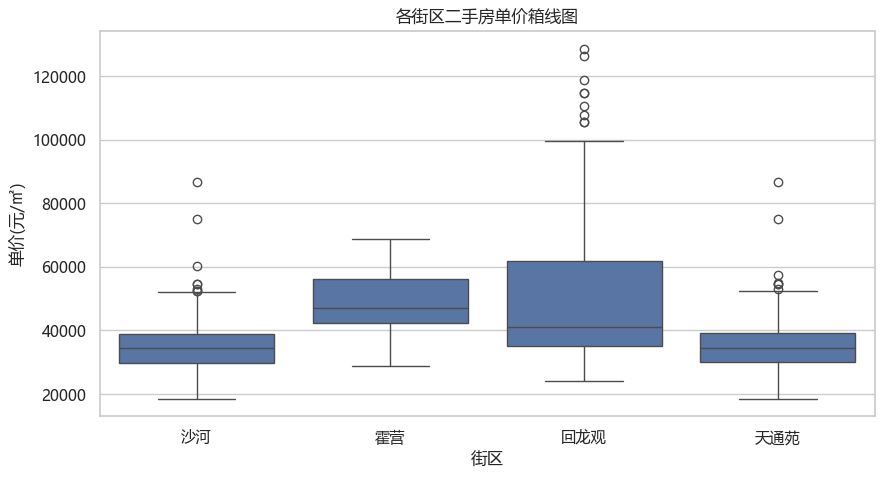

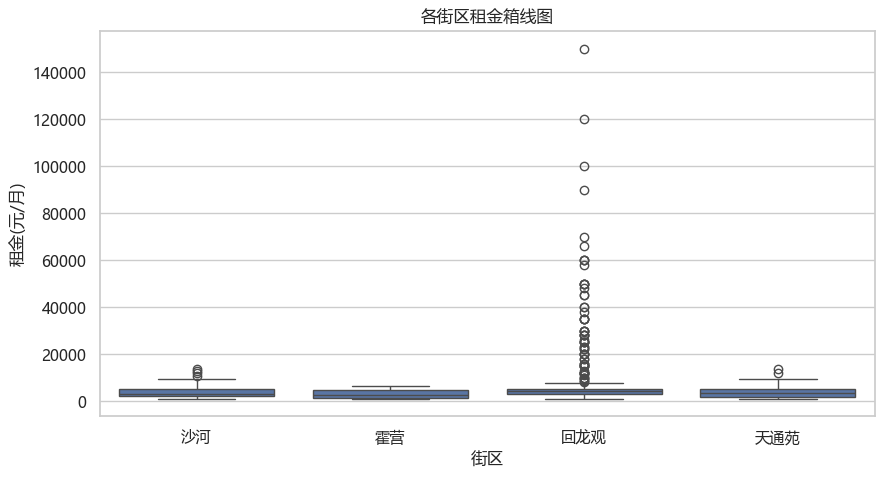

In [63]:
    """ 使用箱线图可视化分布 """
import seaborn as sns
import matplotlib.pyplot as plt

# 绘制二手房单价的箱线图
plt.figure(figsize=(10,5))
sns.boxplot(data=sales_data, y="单价(元/㎡)", x="街区")
plt.title("各街区二手房单价箱线图")
plt.show()

# 绘制租房租金的箱线图
plt.figure(figsize=(10,5))
sns.boxplot(data=rentals_data, y="租金(元/月)", x="街区")
plt.title("各街区租金箱线图")
plt.show()


In [69]:
import pandas as pd

# 读取数据
sales_data = pd.read_excel("合并二手房数据.xlsx")
rentals_data = pd.read_excel("合并租房数据.xlsx")

def remove_outliers(df, column):
    """ 
    使用IQR方法剔除异常值 
    - column: 需要检测异常值的列
    """
    Q1 = df[column].quantile(0.25)  # 计算第一四分位数（25%分位点）
    Q3 = df[column].quantile(0.75)  # 计算第三四分位数（75%分位点）
    IQR = Q3 - Q1  # 计算四分位距
    lower_bound = Q1 - 1.5 * IQR  # 计算下界
    upper_bound = Q3 + 1.5 * IQR  # 计算上界
    
    # 过滤掉异常值
    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df_cleaned

# 剔除二手房数据的异常值（基于单价）
sales_data_cleaned = remove_outliers(sales_data, "单价(元/㎡)")
print(f"剔除异常值后的二手房数据数量: {len(sales_data_cleaned)}")

# 剔除租房数据的异常值（基于租金）
rentals_data_cleaned = remove_outliers(rentals_data, "租金(元/月)")
print(f"剔除异常值后的租房数据数量: {len(rentals_data_cleaned)}")

# 保存剔除异常值后的数据
sales_data_cleaned.to_excel("清洗后_二手房数据.xlsx", index=False)
rentals_data_cleaned.to_excel("清洗后_租房数据.xlsx", index=False)

print("清洗后的数据已保存")

剔除异常值后的二手房数据数量: 1149
剔除异常值后的租房数据数量: 1011
清洗后的数据已保存


4.计算租金价格比及绘制柱状图

     街区  房价租金比
0  回龙观  710.713333
1  天通苑  458.560000
2    沙河  461.066933
3    霍营  538.552941


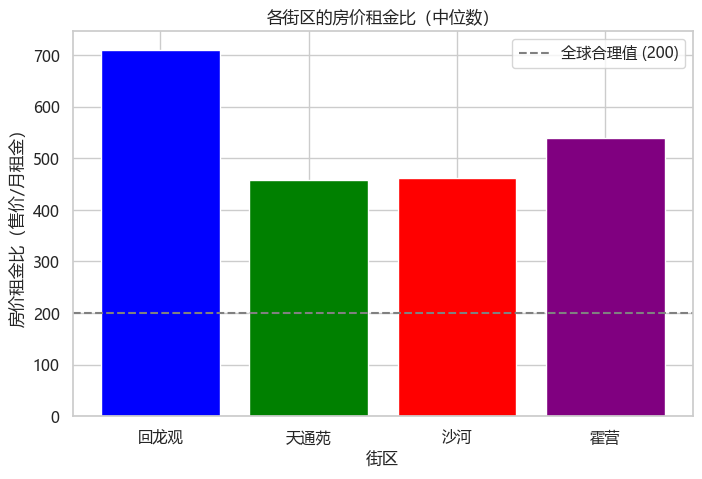

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取清洗后的数据
sales_data = pd.read_excel("清洗后_二手房数据.xlsx")  # 包含 "街区", "单价(元/㎡)"
rentals_data = pd.read_excel("清洗后_租房数据.xlsx")  # 包含 "街区", "租金(元/月)", "面积(㎡)"

sales_price_per_sqm = sales_data.groupby("街区")["单价(元/㎡)"].median()

# 计算每平方米的月租金（租金(元/月) ÷ 面积(㎡)）
rentals_data["月租金(元/㎡)"] = rentals_data["租金(元/月)"] / rentals_data["面积(㎡)"]

# 计算各街区的房价租金比（售价 / 月租金）
price_rent_ratio = sales_price_per_sqm / rentals_data.groupby("街区")["月租金(元/㎡)"].median()

# 转换为 DataFrame
price_rent_ratio_df = price_rent_ratio.reset_index()
price_rent_ratio_df.columns = ["街区", "房价租金比"]

# 打印结果
print(price_rent_ratio_df)

# 绘制房价租金比的柱状图
plt.figure(figsize=(8, 5))
plt.bar(price_rent_ratio_df["街区"], price_rent_ratio_df["房价租金比"], color=["blue", "green", "red", "purple"])
plt.axhline(y=200, color='gray', linestyle='--', label="全球合理值 (200)")
plt.xlabel("街区")
plt.ylabel("房价租金比（售价/月租金）")
plt.title("各街区的房价租金比（中位数）")
plt.legend()
plt.show()

5.预测area=50/100的租售比

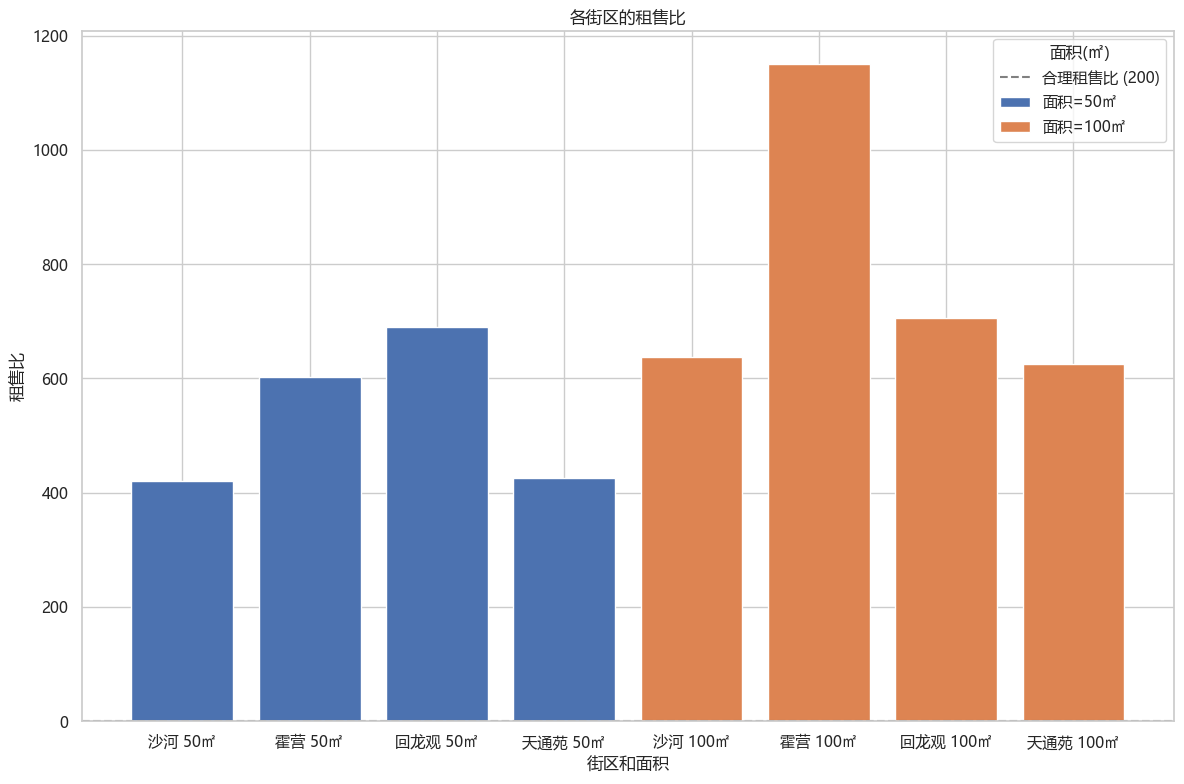

     街区  面积(㎡)  预测单价(元/㎡)  预测每平方米租金(元/㎡)       租售比
0    沙河        50     38807.063990                92.135905   421.193711
1    沙河       100     38790.874754                60.885963   637.107021
2    霍营        50     49101.258763                81.517121   602.342894
3    霍营       100     49090.898197                42.694673  1149.813198
4  回龙观        50     38894.429174                56.376641   689.903274
5  回龙观       100     38899.253670                55.166082   705.129897
6  天通苑        50     38106.751351                89.642756   425.095712
7  天通苑       100     38093.748570                60.989783   624.592296


In [143]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 读取清洗后的数据
sales_data = pd.read_excel("清洗后_二手房数据.xlsx")  # 包含 "街区", "单价(元/㎡)"
rentals_data = pd.read_excel("清洗后_租房数据.xlsx")  # 包含 "街区", "租金(元/月)", "面积(㎡)"

# 街区列编码
location_map = {"沙河": 1, "霍营": 2, "回龙观": 3, "天通苑": 4}
sales_data["location"] = sales_data["街区"].map(location_map)
rentals_data["location"] = rentals_data["街区"].map(location_map)

predicted_sales = []
predicted_rentals = []

# 针对每个街区拟合模型
for location in location_map.values():
    # 筛选当前街区的数据
    sales_data_location = sales_data[sales_data["location"] == location]
    rentals_data_location = rentals_data[rentals_data["location"] == location]

    # 定义并训练模型1（二手房价格预测）
    X_sales = sales_data_location[["面积(㎡)", "location"]].copy()
    X_sales["面积(㎡) × location"] = X_sales["面积(㎡)"] * X_sales["location"]
    y_sales = sales_data_location["单价(元/㎡)"]
    model1 = sm.OLS(y_sales, X_sales).fit()

    # 定义并训练模型2（租金预测）
    X_rentals = rentals_data_location[["面积(㎡)", "location"]].copy()
    X_rentals["面积(㎡) × location"] = X_rentals["面积(㎡)"] * X_rentals["location"]
    y_rentals = rentals_data_location["租金(元/月)"] / rentals_data_location["面积(㎡)"]  # 每平方米租金
    model2 = sm.OLS(y_rentals, X_rentals).fit()

    # 预测不同面积（50㎡和100㎡）的房价和租金
    m2_values = [50, 100]

    for m2 in m2_values:
        # 预测二手房单价
        X_new_sales = pd.DataFrame({
            "面积(㎡)": [m2],
            "location": [location],
            "面积(㎡) × location": [m2 * location]
        })
        predicted_price = model1.predict(X_new_sales)[0]  # 预测单价(元/㎡)

        # 预测租金
        X_new_rentals = pd.DataFrame({
            "面积(㎡)": [m2],
            "location": [location],
            "面积(㎡) × location": [m2 * location]
        })
        predicted_rent = model2.predict(X_new_rentals)[0]  # 预测每平方米租金(元/㎡)

        # 保存预测结果
        predicted_sales.append(predicted_price)  # 保存单价（元/㎡）
        predicted_rentals.append(predicted_rent)  # 保存每平方米租金（元/㎡）

# 将预测结果保存到DataFrame中
predictions = pd.DataFrame({
    "街区": [street for street in location_map.keys() for _ in m2_values],
    "面积(㎡)": m2_values * len(location_map),
    "预测单价(元/㎡)": predicted_sales,
    "预测每平方米租金(元/㎡)": predicted_rentals
})

# 计算租售比
predictions["租售比"] = predictions["预测单价(元/㎡)"] / predictions["预测每平方米租金(元/㎡)"]

# 绘制柱状图
plt.figure(figsize=(12, 8))  # 调整图形大小

# 绘制每个街区和面积的柱状图
for m2 in m2_values:
    data = predictions[predictions["面积(㎡)"] == m2]
    plt.bar(data["街区"] + " " + data["面积(㎡)"].astype(str) + "㎡", data["租售比"], label=f"面积={m2}㎡")

plt.axhline(y=0.05, color='gray', linestyle='--', label="合理租售比 (200)")
plt.xlabel("街区和面积")
plt.ylabel("租售比")
plt.title("各街区的租售比")
plt.legend(title="面积(㎡)")
plt.tight_layout()  # 自动调整布局
plt.show()

# 打印租售比结果
print(predictions)
